In [39]:
%%capture
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install nltk
!pip install wordcloud
!pip install re
!pip install sklearn
!pip install text_preprocessing

In [40]:
# Step 0. Load libraries and custom modules
# Dataframes and matrices ----------------------------------------------
import pandas as pd
import numpy as np
# Graphics -------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
plt.style.use('tableau-colorblind10')
# Mathematical functions -----------------------------------------------
from scipy.stats import norm
# Text processors ------------------------------------------------------
import unicodedata
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
# Preprocessing --------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
# Text modeling --------------------------------------------------------
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
# Model creating -------------------------------------------------------
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
# Metrics --------------------------------------------------------------
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import make_scorer
# Custom functions -----------------------------------------------------
#from text_preprocessing import clean_stopwords
#from text_preprocessing import remove_stopword

In [69]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/gitpod/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [41]:
#del archivo text_preprocessing.py
from text_preprocessing import clean_stopwords

In [42]:
# We'll use a collection of sentiments for text analysis as a dataset
# This dataset was published in Saif M. Mohammad and Peter Turney. (2013), 
# ``Crowdsourcing a Word-Emotion Association Lexicon.'' 
# Computational Intelligence, 29(3): 436-465.
# It's only for research and educational purposes.
# URL: http://saifmohammad.com/WebPages/lexicons.html  
nrc = pd.read_csv('../data/raw/NRC.csv', names=['word','sentiment','polarity'])
nrc = nrc.query('polarity == 1')

In [43]:
# Step 1. Load the data
# Data extracted from https://www.thetrumparchive.com
# Data case: During the 2016 US presidential election, the candidate 
# Donald Trump used twitter to communicate with potential voters. 
# The campaign was during 2015-06-17 and 2016-11-08
# We'll try to analyze these campaign tweets from iPhone and Android
# Data description
# source -> device of origin
# id_str -> unique identifier
# text -> tweet text content
# created_at -> Date of creation, not including timezone
# retweet_count -> Count of retweets (difusion)
# in_reply_to_usr_id_str -> If it's a reply, grab the user id
# favourite_count -> Count of users that liked the tweet
# is_retweet -> If the post is a retweet  
# 1.1 Open data and get a glimpse
df_raw = pd.read_csv('../data/raw/trump_tweets.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20761 entries, 0 to 20760
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   source                   20761 non-null  object 
 1   id_str                   20761 non-null  int64  
 2   text                     20761 non-null  object 
 3   created_at               20761 non-null  object 
 4   retweet_count            20761 non-null  int64  
 5   in_reply_to_user_id_str  2442 non-null   float64
 6   favorite_count           20761 non-null  int64  
 7   is_retweet               20761 non-null  bool   
dtypes: bool(1), float64(1), int64(3), object(3)
memory usage: 1.1+ MB


In [44]:
# 1.1 Sample some observations
df_raw.sample(10)

,source,id_str,text,created_at,retweet_count,in_reply_to_user_id_str,favorite_count,is_retweet
12969,Twitter for iPhone,652925150942392321,"With the fantastic ratings last weekend, @meet...",2015-10-10T19:14:21Z,900,NaN,2016,False
8844,Twitter Web Client,299612268763705344,@rayk71 Happy Birthday Ray.,2013-02-07T20:15:06Z,24,760479018.0,68,False
1470,Twitter Web Client,269122660531855362,@rcthompson01 @cher I agree,2012-11-15T17:00:16Z,25,248938787.0,99,False
18465,Twitter for iPhone,684832481414148096,Huge crowd expected tomorrow night! VT Police ...,2016-01-06T20:22:41Z,1489,NaN,4322,False
347,TweetDeck,142320749271719936,The Fed continues to recklessly flood the mark...,2011-12-01T19:14:45Z,170,NaN,20,False
16594,Twitter for iPhone,753355262363181056,Even the @NYTimes and @WashingtonPost Editoria...,2016-07-13T22:27:45Z,5386,NaN,17798,False
2939,TwitLonger Beta,232566570709299200,China's Olympic training program is abusive ht...,2012-08-06T19:59:25Z,124,NaN,22,False
18218,Twitter for Android,692422072967020544,Just got to listen to Rush Limbaugh - the guy ...,2016-01-27T19:01:01Z,2431,NaN,8497,False
10142,Twitter for Android,529078036772438016,".@SkyscraperLive: Nick, all of the folks at Tr...",2014-11-03T01:10:08Z,120,NaN,205,False
2820,Twitter Web Client,236183191281602560,There's only only one person who has defunded ...,2012-08-16T19:30:35Z,393,NaN,56,False


In [45]:
# Step 2. Transform and wrangle the data
# 2.1 Make a copy
df_interim = df_raw.copy()

In [46]:
# 2.2 Get rid of uninformative columns
df_interim = df_interim.drop(['id_str','is_retweet','in_reply_to_user_id_str'], axis=1)

In [47]:
# 2.3 Convert columns to the right format
df_interim['created_at'] = df_interim['created_at'].astype('datetime64')
df_interim['source'] = pd.Categorical(df_interim['source'])

In [48]:
# 2.4 Filter dates for analysis
df_interim = df_interim.loc[(df_interim['created_at'] >= '2015-06-17') \
    & (df_interim['created_at'] <= '2016-11-08')]

In [49]:
# 2.5 Consider time is UTC, convert to EST
df_interim['created_at'] += pd.Timedelta(-5, unit='h')

In [50]:
# 2.5 Filter source for analysis 
df_interim = df_interim.loc[(df_interim['source'].str.contains('iPhone')) \
    | (df_interim['source'].str.contains('Android'))]
df_interim['source'] = df_interim['source'].cat.remove_unused_categories()

In [51]:
# 2.5 Save and create a copy for analysis
df_interim.to_csv('../data/interim/trump_tweets.csv', index=False)
df = df_interim.copy()

In [52]:
# Step 3. Perform EDA
# 3.1 Get basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3946 entries, 12072 to 18506
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   source          3946 non-null   category      
 1   text            3946 non-null   object        
 2   created_at      3946 non-null   datetime64[ns]
 3   retweet_count   3946 non-null   int64         
 4   favorite_count  3946 non-null   int64         
dtypes: category(1), datetime64[ns](1), int64(2), object(1)
memory usage: 158.0+ KB


In [53]:
# 3.2 Get a sample
df.sample(10)

,source,text,created_at,retweet_count,favorite_count
17701,Twitter for Android,Don't believe the millions of dollars of phony...,2016-03-07 11:50:14,5818,17152
17885,Twitter for iPhone,THANK YOU NEVADA! WE WILL MAKE AMERICA SAFE &a...,2016-02-24 00:41:02,5948,15113
15975,Twitter for iPhone,Thank you Florida- can't wait to see you Frida...,2016-09-14 15:46:23,7126,19706
12181,Twitter for Android,Do you think that Hillary Clinton will apologi...,2015-12-21 13:51:21,3158,8461
12568,Twitter for iPhone,John Kasich was managing director of Lehman Br...,2015-11-19 20:55:47,1679,3720
17285,Twitter for Android,I am happy to hear how badly the @nytimes is d...,2016-04-24 20:27:12,4568,14715
17058,Twitter for iPhone,Thank you Oregon! #Trump2016 \n#MakeAmericaGre...,2016-05-17 22:15:07,4921,15360
16456,Twitter for iPhone,Sad to watch Bernie Sanders abandon his revolu...,2016-07-25 22:04:56,23360,67692
12798,Twitter for iPhone,I'm sure the media will not report the highly ...,2015-10-28 12:51:07,2361,3516
12454,Twitter for iPhone,The truth continues to come out after 14 years...,2015-12-01 21:20:51,2540,4594


In [54]:
# 3.3 Describe numerical and datetime data
df.describe(datetime_is_numeric=True)

,created_at,retweet_count,favorite_count
count,3946,3946.000000,3946.000000
mean,2016-03-31 07:49:53.323872256,5839.465281,15666.982767
min,2015-06-19 20:03:05,61.000000,167.000000
25%,2015-12-20 18:19:10.500000,2013.250000,5350.000000
50%,2016-03-16 05:29:30.500000,4162.500000,11981.500000
75%,2016-07-25 09:04:26.500000,7807.250000,21527.000000
max,2016-11-07 17:21:53,168765.000000,297281.000000
std,NaN,6156.818896,14650.408743


In [55]:
# 3.4 Describe categorical data
df['source'].value_counts()

Twitter for iPhone     2099
Twitter for Android    1847
Name: source, dtype: int64

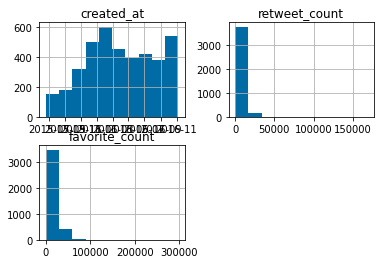

In [56]:
# 3.5 Get histograms for numerical data
df.hist()
plt.show()

In [57]:
# 3.6 Make a plot of tweets frequence rate by source
df_plot = (df
            .assign(hour=df['created_at'].dt.hour)
            .groupby(['source','hour'])
            .agg(count=('source','count'))
            .assign(rate=lambda df: df['count'] / df.groupby('source')['count'].sum())
            .reset_index())
df_plot

,source,hour,count,rate
0,Twitter for Android,0,22,0.011911
1,Twitter for Android,1,2,0.001083
2,Twitter for Android,2,6,0.003249
3,Twitter for Android,3,1,0.000541
4,Twitter for Android,4,28,0.015160
5,Twitter for Android,5,98,0.053059
6,Twitter for Android,6,159,0.086086
7,Twitter for Android,7,194,0.105035
8,Twitter for Android,8,210,0.113698
9,Twitter for Android,9,132,0.071467


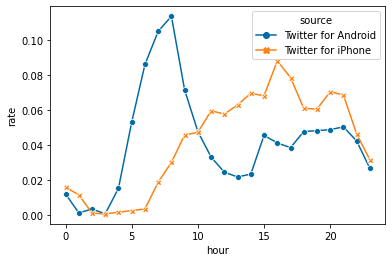

In [59]:
sns.lineplot(data=df_plot, x='hour', y='rate', hue='source', markers=True, style='source', dashes=False)
plt.show()

In [62]:
# 3.7 Get a glimpse of the most retweeted tweets
df.sort_values(by='retweet_count', ascending=False)[['text', 'retweet_count']][:10]

,text,retweet_count
16875,How long did it take your staff of 823 people ...,168765
17183,Happy #CincoDeMayo! The best taco bowls are ma...,85465
15333,MAKE AMERICA GREAT AGAIN!,59098
15758,Here is my statement. https://t.co/WAZiGoQqMQ,51891
16548,Such a great honor to be the Republican Nomine...,41616
15340,If Obama worked as hard on straightening out o...,41479
15827,For those few people knocking me for tweeting ...,40850
15756,The media and establishment want me out of the...,40772
16583,I am pleased to announce that I have chosen Go...,38782
16848,Is President Obama going to finally mention th...,38456


In [64]:
# 3.8 Get a glimpse of the most liked tweets
df.sort_values(by='favorite_count', ascending=False)[['text', 'favorite_count']][:10]

,text,favorite_count
16875,How long did it take your staff of 823 people ...,297281
16548,Such a great honor to be the Republican Nomine...,129652
15758,Here is my statement. https://t.co/WAZiGoQqMQ,120244
15781,Mike Pence won big. We should all be proud of ...,120189
17183,Happy #CincoDeMayo! The best taco bowls are ma...,119759
15333,MAKE AMERICA GREAT AGAIN!,115387
15827,For those few people knocking me for tweeting ...,107497
15756,The media and establishment want me out of the...,105680
15340,If Obama worked as hard on straightening out o...,102045
16583,I am pleased to announce that I have chosen Go...,92250


In [65]:
# 3.9 Let's get a glimpse of common words in the tweets' text
df['text'].str.split(expand=True).stack().value_counts()[:10]

the    1965
to     1369
and    1186
I      1133
in     1098
a       987
of      957
is      904
on      829
for     703
dtype: int64

In [70]:
# 3.10 Process text to extract stopwords
df['text_clean'] = df.text.str.lower()
stop_dict = stopwords.words('english')
df['text_clean'] = df['text_clean'].apply(lambda x: clean_stopwords(x, stop_dict=stop_dict))
df['text_clean'] = df['text_clean'].str.replace(r'''['!,.]''','',regex=True)

In [71]:
df.head(10)

,source,text,created_at,retweet_count,favorite_count,text_clean
12072,Twitter for Android,I would like to wish everyone A HAPPY AND HEAL...,2015-12-31 18:21:49,6776,16495,would like wish everyone happy healthy new yea...
12073,Twitter for Android,"Do you believe that The State Department, on N...",2015-12-31 18:11:35,2755,6824,believe state department new years eve release...
12074,Twitter for iPhone,THANK YOU ILLINOIS! Let's not forget to get fa...,2015-12-31 13:51:12,2468,6047,thank illinois lets forget get family &amp; fr...
12075,Twitter for iPhone,"HAPPY BIRTHDAY to my son, @DonaldJTrumpJr! Ver...",2015-12-31 11:52:38,2080,8416,happy birthday son @donaldjtrumpjr proud you #...
12076,Twitter for Android,I would feel sorry for @JebBush and how badly ...,2015-12-31 10:07:18,1875,5780,would feel sorry @jebbush badly campaign fact ...
12077,Twitter for iPhone,#MakeAmericaGreatAgain #Trump2016 https://t.co...,2015-12-31 07:51:35,2285,5729,#makeamericagreatagain #trump2016 https://tco/...
12078,Twitter for Android,"People ask, ""why do you tweet and re-tweet to ...",2015-12-31 05:04:36,1359,4248,"people ask ""why tweet re-tweet millions @jebbu..."
12079,Twitter for Android,".@JebBush has spent $63,000,000 and is at the...",2015-12-31 00:10:16,2374,6655,@jebbush spent $63000000 bottom polls spent al...
12080,Twitter for Android,A GREAT day in South Carolina. Record crowd an...,2015-12-30 23:15:32,1706,5715,great day south carolina record crowd fantasti...
12081,Twitter for Android,"I predict that dying @UnionLeader newspaper, w...",2015-12-30 23:11:37,897,3261,predict dying @unionleader newspaper run groun...


In [72]:
# 3.11 Extract urls
url_pat = 'https://t.co/[A-Za-z\d]+|&amp;'
df['text_clean'] = df['text_clean'].str.replace(url_pat,'',regex=True)

In [73]:
# 3.12 Extract special characters
df['text_clean'] = df['text_clean'].str.replace(r'''[!.,():\-%$/'"']''','',regex=True)

In [74]:
# 3.13 Extract numbers
df['text_clean'] = df['text_clean'].str.replace( r'[\d]+','',regex=True)


In [76]:
# 3.14 See the results
df[['text', 'text_clean']].sample(10)

,text,text_clean
15405,If my people said the things about me that Pod...,people said things podesta hillarys people sa...
17529,MAKE AMERICA GREAT AGAIN!,make america great again
15337,The only thing that can stop this corrupt mach...,thing stop corrupt machine you force strong en...
18152,Join us! #CaucusForTrump\n11am WATERLOO: https...,join us #caucusfortrump am waterloo httpstcodg...
12749,Few people know that @FortuneMagazine is stil...,people know @fortunemagazine still business te...
16082,From day one I said that I was going to build ...,day one said going build great wall southern b...
16153,I have been drawing very big and enthusiastic ...,drawing big enthusiastic crowds media refuses ...
16766,Leaving now for a one night trip to Scotland i...,leaving one night trip scotland order grand op...
18351,Wow! Ted Cruz received $487K in campaign contr...,wow ted cruz received k campaign contributions...
12400,Hillary just said that she will not use the te...,hillary said use term radical islamic incapab...


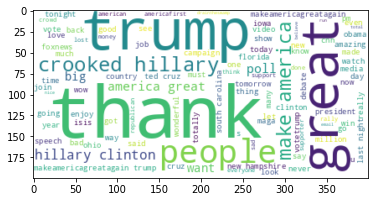

In [82]:
# 3.15 Let's see a wordcloud
text = ' '.join(i for i in df.text_clean)
wordcloud = WordCloud(max_words=100, background_color='White').generate(text)
plt.Figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()


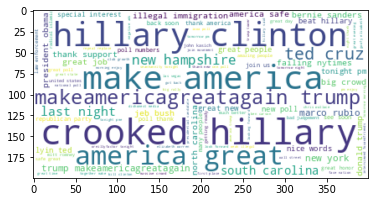

In [83]:
# Dos palabras que se repiten una y otra vez - Bigramo - dos palabras que van juntas
# y ver cuantas veces se repiten
wordcloud_bg = WordCloud(collocation_threshold=2, collocations=True, max_words=100, background_color='White').generate(text)
plt.Figure(figsize=(12,12))
plt.imshow(wordcloud_bg, interpolation='bilinear')
plt.show()

In [84]:
# Trocear el texto, asociar las palabras con los sentimientos
df_word_split = (df
                 .drop(['text', 'created_at', 'retweet_count', 'favorite_count'], axis=1)
                 .assign(text=df['text_clean'].str.split())).explode('text').drop('text_clean', axis=1).rename(columns={'text':'word'})
df_word_split

,source,word
12072,Twitter for Android,would
12072,Twitter for Android,like
12072,Twitter for Android,wish
12072,Twitter for Android,everyone
12072,Twitter for Android,happy
...,...,...
18506,Twitter for Android,together
18506,Twitter for Android,make
18506,Twitter for Android,america
18506,Twitter for Android,great


In [85]:
# Aplicamos join
df_word_split.merge(nrc[['word', 'sentiment']], on='word', how='inner')

,source,word,sentiment
0,Twitter for Android,happy,anticipation
1,Twitter for Android,happy,joy
2,Twitter for Android,happy,positive
3,Twitter for Android,happy,trust
4,Twitter for iPhone,happy,anticipation
...,...,...,...
17547,Twitter for Android,stiff,negative
17548,Twitter for Android,embarrassment,fear
17549,Twitter for Android,embarrassment,negative
17550,Twitter for Android,embarrassment,sadness


In [86]:
df_sent = df_word_split.\
        merge(nrc[['word', 'sentiment']], on='word', how='inner').\
        groupby(['source', 'sentiment']).agg(count=('sentiment', 'count')).\
        reset_index().pivot_table(index=['sentiment'], columns=['source'], values='count').\
        reset_index().\
        rename(columns={'Twitter for Android':'Android','Twitter for iPhone':'iPhone'})

df_sent



source,sentiment,Android,iPhone
0,anger,949,514
1,anticipation,986,725
2,disgust,632,307
3,fear,815,477
4,joy,743,543
5,negative,1671,925
6,positive,1963,1522
7,sadness,911,512
8,surprise,587,385
9,trust,1363,1022


In [91]:
# Frecuencias Relativas
# Odd Ratios
# Vamos a calcular un intervalo de confianza

df_odd_ratio = df_sent.\
                assign(odd_ratio=(df_sent['Android']/(df_sent['Android'].sum()-df_sent['Android']))/(df_sent['iPhone']/(df_sent['iPhone'].sum()-df_sent['iPhone'])))

#Creamos columna con el logaritmo
df_odd_ratio['log_or'] = np.log(df_odd_ratio['odd_ratio'])




In [92]:
df_odd_ratio.sort_values(by='log_or', ascending=False)

source,sentiment,Android,iPhone,odd_ratio,log_or
2,disgust,632,307,1.365482,0.311508
0,anger,949,514,1.225269,0.203160
5,negative,1671,925,1.212601,0.192767
7,sadness,911,512,1.176546,0.162583
3,fear,815,477,1.124833,0.117634
8,surprise,587,385,0.994922,-0.005091
4,joy,743,543,0.885109,-0.122044
1,anticipation,986,725,0.876222,-0.132136
9,trust,1363,1022,0.851456,-0.160808
6,positive,1963,1522,0.806001,-0.215670


In [93]:
# Vamos a crear intervalos de confianza
# error standard
df_odd_ratio['se'] = np.sqrt(1/df_odd_ratio['Android']+1/(df_odd_ratio['Android'].sum()-df_odd_ratio['Android'])+1/df_odd_ratio['iPhone']+1/(df_odd_ratio['iPhone'].sum()-df_odd_ratio['iPhone']))
df_odd_ratio['conf_low'] = df_odd_ratio['log_or'] - norm.ppf(0.975) * df_odd_ratio['se']
df_odd_ratio['conf_high'] = df_odd_ratio['log_or'] + norm.ppf(0.975) * df_odd_ratio['se']
df_odd_ratio.sort_values(by='log_or', ascending=False)

source,sentiment,Android,iPhone,odd_ratio,log_or,se,conf_low,conf_high
2,disgust,632,307,1.365482,0.311508,0.071349,0.171666,0.451349
0,anger,949,514,1.225269,0.203160,0.057083,0.091280,0.315041
5,negative,1671,925,1.212601,0.192767,0.044246,0.106046,0.279489
7,sadness,911,512,1.176546,0.162583,0.057529,0.049828,0.275338
3,fear,815,477,1.124833,0.117634,0.059836,0.000358,0.234910
8,surprise,587,385,0.994922,-0.005091,0.067479,-0.137347,0.127165
4,joy,743,543,0.885109,-0.122044,0.058697,-0.237087,-0.007001
1,anticipation,986,725,0.876222,-0.132136,0.051560,-0.233192,-0.031081
9,trust,1363,1022,0.851456,-0.160808,0.044602,-0.248227,-0.073388
6,positive,1963,1522,0.806001,-0.215670,0.038299,-0.290735,-0.140606


Intervalo de confianza no contiene cero, es probable que pertenezca a Android. 

Si contiene cero pude ser que sea al azar. 

Esta bien separado las emociones positivas con las negativas.

Surprise contiene cero, no puedo discernir si es de Android o iPhone.

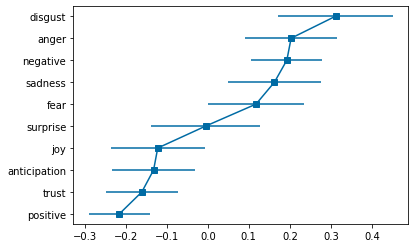

In [96]:
df_odd_ratio = df_odd_ratio.sort_values(by='log_or', ascending=True)
plt.errorbar(df_odd_ratio['log_or'], df_odd_ratio['sentiment'],marker='s',xerr=((df_odd_ratio.log_or-df_odd_ratio.conf_low),(df_odd_ratio.conf_high-df_odd_ratio.log_or)))
plt.show()